In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
import json
import glob

PROJECT_DIR = os.getcwd()

In [3]:
import json
from src.utils import utils
import trimesh
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

from src.eval import chamfer_distance, crop_points_to_bbox, \
    compute_transformation_error, pose_estimate

In [5]:
dataset_name = "box_v4_stage1"
run_name = "run2_age15"
known_idx = 24
dataset_info = utils.get_dataset_info(dataset_name, PROJECT_DIR)
dataset_info["data"]

{'path': '/home/yudzyoga/Documents/Courses/2ndSemester/3DCV/Assignments/github/3dcv_group_10/Project/Submission/dataset/box_v4_stage1',
 'image': '/home/yudzyoga/Documents/Courses/2ndSemester/3DCV/Assignments/github/3dcv_group_10/Project/Submission/dataset/box_v4_stage1/images',
 'correspondence': 'correspondences'}

### Produce Final detection result

In [37]:
f_gt = open(os.path.join(dataset_info["data"]["path"], "gt_camera_parameters.json"), "r")
camera_param_gt = json.load(f_gt)


f_data = open(os.path.join(dataset_info["data"]["path"], f"result/{run_name}/known_camera_extrinsics_{known_idx}.json"), "r")
camera_param_data = json.load(f_data)

In [28]:
img_idx = np.array([int(os.path.basename(i).split(".")[0]) for i in glob.glob(os.path.join(dataset_info["data"]["image"], "*.jpg"))])
img_idx = sorted(img_idx)

In [29]:
ratio = 1

key_2nd = list(camera_param_data.keys())[1]
ratio = (1/np.linalg.norm(np.array(camera_param_data[key_2nd]).reshape(4, 4)[:3, 3]))

In [30]:
out_camera = {"extrinsics": {}}
last_available = 0
for i in img_idx:
    ext = []
    if f"i{i}" in list(camera_param_data.keys()):
        ext = camera_param_data[f"i{i}"]
        last_available = i
    else:
        ext = camera_param_data[f"i{last_available}"]
    ext = np.array(ext).reshape(4, 4)
    ext[0, 3] = -ext[0, 3] * ratio
    ext[:3, :3] = ext[:3, :3].T

    out_camera["extrinsics"]["{:05}.jpg".format(i)] = ext.tolist()

In [121]:
utils.export_json(os.path.join(dataset_info["data"]["path"], "estimated_camera_parameters.json"), out_camera)

### Visualize

In [31]:
# visualize_param = camera_param_gt 
visualize_param = out_camera 

camera_extrinsics = np.array([visualize_param["extrinsics"]["{:05}.jpg".format(idx)] for idx in img_idx])

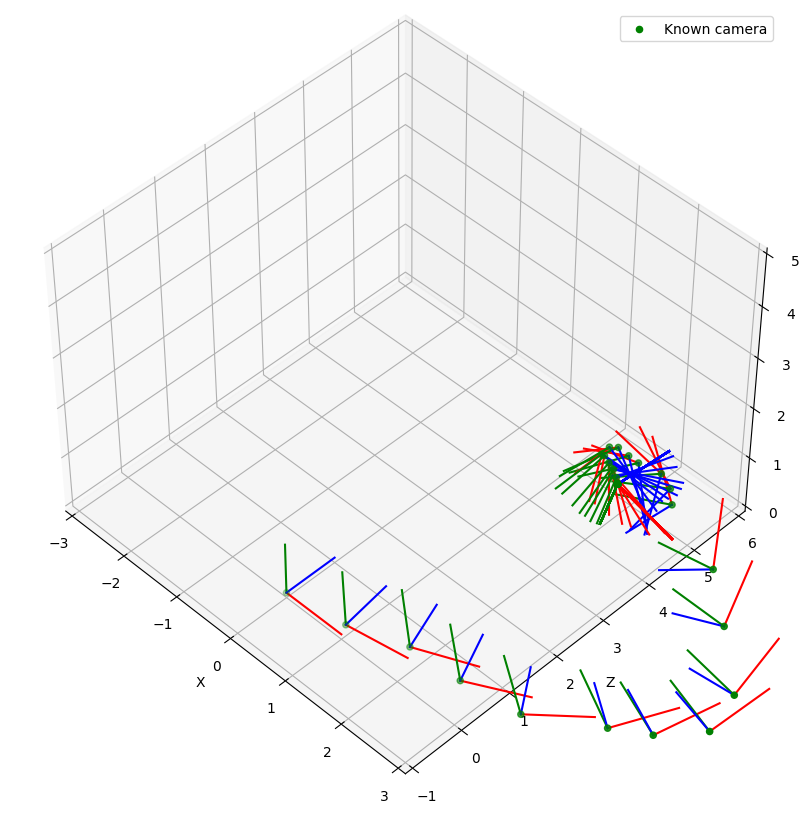

In [32]:
fixed_camera_origin_direction = [np.zeros(12) for i in camera_extrinsics]
for j, ext_cam in enumerate(camera_extrinsics):
    # ray = Tools.reproject_ray(camera_intrinsic, ext_cam, (960, 540))
    fixed_camera_origin_direction[j][:3] = ext_cam[:3, 3]
    dir_x, dir_y, dir_z = np.array([1, 0, 0, 1]), np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])
    fixed_camera_origin_direction[j][3:6] = ext_cam.dot(dir_x)[:3]
    fixed_camera_origin_direction[j][6:9] = ext_cam.dot(dir_y)[:3]
    fixed_camera_origin_direction[j][9:12] = ext_cam.dot(dir_z)[:3]
fixed_camera_origin_direction = np.array(fixed_camera_origin_direction)

ax = plt.figure(figsize=(15, 10)).add_subplot(projection='3d')
color = ["r", "g", "b"]

# training - scatter pt and cam
ax.scatter(xs=fixed_camera_origin_direction[:, :3][:, 0], ys=fixed_camera_origin_direction[:, :3][:, 1], zs=fixed_camera_origin_direction[:, :3][:, 2], zdir='y', label='Known camera', c='g')

# known - plot cam
for cam_data_fixed in fixed_camera_origin_direction:
    for k_idx, k in enumerate(cam_data_fixed[3:].reshape(3, 3)):
        start = cam_data_fixed[:3]
        end = k / np.linalg.norm(k - start)# / np.linalg.norm(k)#cam_data[:3] + cam_data[3:]
        # end = cam_data[:3] + cam_data[3:6]
        poses = np.array([start, end]).reshape(-1, 3)
        ax.plot(xs=poses[:, 0], ys=poses[:, 1], zs=poses[:, 2], zdir="y", c=color[k_idx])

ax.view_init(elev=45., azim=-45, roll=0)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 6)
ax.set_zlim(0, 5)

ax.legend()

In [19]:
# def visualize(cam1_ext, cam2_ext, pt3d):
#     cams = [cam1_ext, cam2_ext]

#     fixed_camera_origin_direction = [np.zeros(12) for i in cams]
#     for j, ext_cam in enumerate(cams):
#         # ray = Tools.reproject_ray(camera_intrinsic, ext_cam, (960, 540))
#         fixed_camera_origin_direction[j][:3] = ext_cam[:3, 3]
#         # fixed_camera_origin_direction[j][3:] = ray[1]
#         dir_x, dir_y, dir_z = np.array([1, 0, 0, 1]), np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])
#         fixed_camera_origin_direction[j][3:6] = ext_cam.dot(dir_x)[:3]
#         fixed_camera_origin_direction[j][6:9] = ext_cam.dot(dir_y)[:3]
#         fixed_camera_origin_direction[j][9:12] = ext_cam.dot(dir_z)[:3]
#     fixed_camera_origin_direction = np.array(fixed_camera_origin_direction)

#     ax = plt.figure(figsize=(15, 10)).add_subplot(projection='3d')

#     color = ["r", "g", "b"]
#     # training - scatter pt and cam
#     ax.scatter(xs=pt3d[:, 0], ys=pt3d[:, 1], zs=pt3d[:, 2], zdir='y', label='Known pts', c='magenta')
#     ax.scatter(xs=fixed_camera_origin_direction[:, :3][:, 0], ys=fixed_camera_origin_direction[:, :3][:, 1], zs=fixed_camera_origin_direction[:, :3][:, 2], zdir='y', label='Known camera', c='g')

#     # known - plot cam
#     for cam_data_fixed in fixed_camera_origin_direction:
#         for k_idx, k in enumerate(cam_data_fixed[3:].reshape(3, 3)):
#             start = cam_data_fixed[:3]
#             end = k / np.linalg.norm(k - start)# / np.linalg.norm(k)#cam_data[:3] + cam_data[3:]
#             # end = cam_data[:3] + cam_data[3:6]
#             poses = np.array([start, end]).reshape(-1, 3)
#             ax.plot(xs=poses[:, 0], ys=poses[:, 1], zs=poses[:, 2], zdir="y", c=color[k_idx])

#     ax.view_init(elev=45., azim=-45, roll=0)
#     ax.set_xlabel("X")
#     ax.set_ylabel("Z")
#     ax.set_zlabel("Y")
#     ax.set_xlim(-3, 3)
#     ax.set_ylim(-1, 5)
#     ax.set_zlim(0, 5)

#     ax.legend()

### Build 3D point clouds

In [238]:
import trimesh

In [38]:
f_data = open(os.path.join(dataset_info["data"]["path"], f"result/{run_name}/known_3d_points_{known_idx}.json"), "r")
points_param_data = json.load(f_data)
pts_3d = np.array([i["pos"] for i in points_param_data.values()]) * ratio
pts_3d[:, 1] = - pts_3d[:, 1]

In [39]:
pc_output = os.path.join(dataset_info["data"]["path"], "estimated_points.ply")
mesh = trimesh.Trimesh(vertices=pts_3d)
mesh.export(pc_output)

b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 1539\nproperty float x\nproperty float y\nproperty float z\nelement face 0\nproperty list uchar int vertex_indices\nend_header\n\xa85i@paY?>k\tA\xa5\xb1]@O5\x82?ij\x00A\xfb\x83w@\xad\xc6\x89?x\xf4\xf9@\x0c\xcfS@\xf4a\x85?\xceZ\xfc@%\x08w@Za\x90?\x08\xef\xf6@\xa2N\xb8?\x8b\x1b\x93?\xeb\xfa\xea@~\xcc\xc6?\xf0\xfe3?\x08\x9e\x14Aizi@\xfa\xdam?\x02\xd7\x08AP\r\x80@\x0eYs?\x9e\xf6\x05AZ\rX@Z\rt?\x8f\xee\x02A\xcf|8@-\xd4\xb2?^a\xd4@\x9d,?@4\xac\xb4?\x07\xe7\xd1@\x01E\r@,6\xdf?\xf7<\xaf@\x10:}@v\xdfZ?S\x07\x05AX\x13m@\xa4Oa?\xe65\x06A\xc5\xd4-@\xed\xef\xba?\xb1\xa5\xcc@*\x82\x1c@\xf9s\xbb?\xf1\x0f\xcd@\xcf<q?\xea\x04\xc1?\x8c8\xc4@\x8c\r&?)!\xcb?\xab9\xbc@\xd7`\xa6\xbf\r\xfa\x93\xbeU\x1d\xa6@xX\x1a@U\x04K?\xc7q\tA\x0b\xc6\x83@\xb3\xbc\x82?\xbe\x11\x02A\\3\x05@\x81\x7fa?6J\tA\x07Q}@\xe1\x1e\x81?D\'\x02A\x03\xf1c@\xb48\x83?\xfdB\xff@Tt\xce?\xd5\xea\x9a?yT\xe5@\xe9\x93P\xc0\x193\xbc?\xa3\xe2\xfb@u\x8

In [237]:
print(mesh.bounds)

None
